# Import libraries and packages

In [1]:
# Importing the libraries and packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import re
import csv
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
# tokenization 
!pip install -U nltk
import nltk
import sys
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import nltk.data
import pickle
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Prepare Data for the Model

### Load dataset
Add the data from train.csv into **data** as list of lists. Each element of this list **data** is again a list of sentences, the first sentence is the *source sentence*,  and the second sentence is the corresponding *target sentence*.

In [5]:
labels = ['LABEL1', 'LABEL2']
onehot = OneHotEncoder(categories=[labels])
onehot.fit(np.array(labels).reshape(-1, 1))

OneHotEncoder(categories=[['LABEL1', 'LABEL2']])

In [6]:
dataset = pd.read_csv("../input/proj-dataset/en-fr_es_new.csv", index_col=0).reset_index(drop=True)
#train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=False)
train_data = dataset.copy()
test_data = dataset[-5000:]

In [7]:
# save
train_data.to_csv("train_p2.csv", index=False)
test_data.to_csv("test_p2.csv", index=False)

In [8]:
# load
train_data = pd.read_csv("train_p2.csv", index_col=False)
test_data = pd.read_csv("test_p2.csv", index_col=False)



### Pre-processing

In [9]:
# performing tokenization on the sentences

def lang_tokenizer(label, sentence):
  language = ""
  if label == "ENGLISH":
     language = 'english'
  elif label =='FRENCH':
     language = 'french'
  elif label == 'SPANISH':
     language = 'spanish'
  elif label == "GREEK":
     language = 'greek'
  regex = re.compile(r'[@_!♫♪#$%^&*(.,)<>?/\|}{~:;-]')
  sentence = regex.sub('',sentence)                  
  sentence = sentence.lower()   
  token_list = word_tokenize(sentence,language=language)                                  #tokenization
  return token_list 

In [10]:
# vocab class for the word to index and index to word mapping

class Vocab:
   def __init__(self):
     self.word2index = {"<unk>":0 , "<sos>":1, "<eos>":2, "<pad>":3}
     self.index2word = {0:"<unk>" , 1:"<sos>", 2:"<eos>", 3:"<pad>"}
     self.vocab_size = len(self.word2index)
     self.word_count = {"<unk>":1 , "<sos>":1, "<eos>":1, "<pad>":1}

   def add_to_vocab(self,token_list):
     for token in token_list:
        if token not in self.word2index:        #add to vocab only if its not already present 
           ind = len(self.word2index)
           self.word2index[token] = ind
           self.index2word[ind] = token
           self.vocab_size += 1
           self.word_count[token] = 1
        else:
           self.word_count[token] += 1  
           
   def tokens2tensor(self,token_list):
      token_indices = list()
      
      #for each token, append its index as per the built vocabulary. If token is not present in the vocab, append the index of <unk> 
      for token in token_list:
          if token in self.word2index:
              token_indices.append(self.word2index[token])
          else:
              token_indices.append(self.word2index["<unk>"])

      #convert the token_indices into tensor              
      sentence_tensor = torch.tensor(token_indices).unsqueeze(1).to(device)
      
      return sentence_tensor

In [11]:
token_columns = {"src_token_indices":[], "label_token_indices":[],"tgt_token_indices":[]}

src_field = Vocab()
tgt_field = Vocab()
for i in range(len(train_data)):
   
   temp_src = train_data['source'].iloc[i]
   temp_tgt = train_data['target'].iloc[i]
   temp_label = train_data['labels'].iloc[i]

   #tokenisation
   src_tokens = lang_tokenizer(temp_label, temp_src)
   tgt_tokens = lang_tokenizer(temp_label, temp_tgt)

   #add to vocab
   src_field.add_to_vocab(src_tokens)
   tgt_field.add_to_vocab(tgt_tokens)

   #convert tokens to indices and add <sos> at the beginning ang <eos> at the end
   src_indices = [src_field.word2index['<sos>']] + [src_field.word2index[token] if token in src_field.word2index else src_field.word2index["<unk>"] for token in src_tokens] + [src_field.word2index['<eos>']]
   tgt_indices = [tgt_field.word2index['<sos>']] + [tgt_field.word2index[token] if token in tgt_field.word2index else tgt_field.word2index["<unk>"] for token in tgt_tokens] + [tgt_field.word2index['<eos>']]
   
   #add to dictionary
   token_columns["src_token_indices"].append(src_indices)
   token_columns["tgt_token_indices"].append(tgt_indices)


train_data["src_token_indices"] =  token_columns["src_token_indices"]
train_data["tgt_token_indices"] =  token_columns["tgt_token_indices"]

#calculate the no of tokens in src
train_data["len_of_src"] = train_data["src_token_indices"].apply(len)
train_data["len_of_tgt"] = train_data["tgt_token_indices"].apply(len)
train_data

,source,target,labels,src_token_indices,tgt_token_indices,len_of_src,len_of_tgt
0,after the introduction of the notes and coins ...,"después de la introducción, el 1 de enero de 2...",SPANISH,"[1, 4, 5, 6, 7, 5, 8, 9, 10, 11, 12, 13, 14, 1...","[1, 4, 5, 6, 7, 8, 9, 5, 10, 5, 11, 5, 12, 13,...",21,23
1,"this reform project needs, however, to be cons...","ahora bien, hay que abordar con prudencia este...",SPANISH,"[1, 21, 22, 23, 24, 25, 26, 19, 27, 28, 29, 2]","[1, 21, 22, 23, 24, 25, 26, 27, 28, 29, 5, 30, 2]",12,13
2,"however, in order for venezuela to be a full m...","cependant, afin que le venezuela soit un membr...",FRENCH,"[1, 25, 30, 31, 32, 33, 26, 19, 34, 35, 36, 37...","[1, 31, 32, 24, 33, 34, 35, 36, 37, 38, 39, 40...",21,21
3,it is high time that these promises were kept.,il est grand temps qu'ils tiennent leurs prome...,FRENCH,"[1, 43, 44, 45, 46, 37, 47, 48, 49, 50, 2]","[1, 49, 50, 51, 52, 53, 54, 55, 56, 57, 41, 58...",11,13
4,i would like to go through one or two detailed...,je voudrais aborder une ou deux questions préc...,FRENCH,"[1, 51, 52, 53, 26, 54, 55, 56, 57, 58, 59, 60...","[1, 59, 60, 61, 62, 63, 64, 65, 66, 67, 5, 68,...",21,19
...,...,...,...,...,...,...,...
59995,the second stage agreement is not perfect.,l'accord de deuxième phase n'est pas parfait.,FRENCH,"[1, 5, 440, 1873, 1295, 44, 127, 3809, 2]","[1, 6575, 5, 549, 1287, 357, 198, 5868, 2]",9,9
59996,here we are contributing to adding value to th...,nous contribuons ici à ajouter de la valeur au...,FRENCH,"[1, 402, 120, 74, 11293, 26, 12998, 3049, 26, ...","[1, 160, 5621, 1982, 38, 3294, 5, 6, 7926, 229...",17,18
59997,the commissioner’s statement suggests this cou...,la déclaration du commissaire montre que cela ...,FRENCH,"[1, 5, 586, 260, 261, 482, 224, 21, 561, 19, 1...","[1, 6, 608, 217, 1217, 211, 24, 413, 1225, 44,...",12,12
59998,they must serve justice and the rule of law.,deben apegarse a la justicia y al estado de de...,SPANISH,"[1, 144, 93, 4774, 2545, 9, 5, 95, 7, 1197, 2]","[1, 1598, 44788, 93, 6, 9308, 13, 501, 4507, 5...",11,12


In [12]:
#print(sum(train_data["labels"]=="FRENCH")) 
#print(sum(train_data["labels"]=="SPANISH")) 

# EQUAL NUMBER OF TARGET 1 AND TARGET 2 SETENCES
train_data =  train_data.sort_values(by="labels")
train_data = pd.concat([train_data[:25000],train_data[-25000:]])

#print(sum(train_data["labels"]=="FRENCH")) 
#print(sum(train_data["labels"]=="SPANISH"))

In [13]:

max_src_len = max(train_data["len_of_src"])
max_tgt_len = max(train_data["len_of_tgt"])

# NUMBER OF BATCHES 
batch_size =8

In [14]:
# APPLYING PADDING TO MAKE BATCHES OF SIMILAR SIZE

def add_padding(token_list,length,field):
    while len(token_list)<length:
       token_list.append(field.word2index["<pad>"])
    return token_list

In [15]:
batch_list = list()

In [16]:
# CLASSES = ['FRENCH','SPANISH'] (  OR ['FRENCH' , 'GREEK'] depending on the dataset)

classes = ['FRENCH', 'SPANISH']
onehot_encoder = OneHotEncoder(categories=[classes])
train_labels = onehot_encoder.fit_transform(np.array(train_data['labels']).reshape(-1, 1)).toarray()

In [17]:
for i in range(0,len(train_data),batch_size):
   batch  =  train_data[i:i+batch_size]
   src_tlen = max(batch["len_of_src"])
   tgt_tlen = max(batch["len_of_tgt"])
   train_data[i:i+batch_size]["src_token_indices"] = train_data[i:i+batch_size]["src_token_indices"].apply(add_padding, args=(src_tlen,src_field)) 
   train_data[i:i+batch_size]["tgt_token_indices"] = train_data[i:i+batch_size]["tgt_token_indices"].apply(add_padding, args=(tgt_tlen,tgt_field)) 

   src = np.vstack(list(train_data[i:i+batch_size]["src_token_indices"]))
   tgt = np.vstack(list(train_data[i:i+batch_size]["tgt_token_indices"]))

   batch_list.append([ src, tgt, train_labels[i:i+batch_size]])
    
random.shuffle(batch_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Model

# CONCATENATION OF THE CONDITIONAL LABELS

concatenating the onehot representation of conditional labels with the latent space vectors producedby  the  encoder stack. 

In [18]:
'''
L - number of layers
N - batch size
H - hidden size
C - conditional label size
'''

'\nL - number of layers\nN - batch size\nH - hidden size\nC - conditional label size\n'

In [19]:
# a : L * N * H
# b : N * C
# return : L * N * (H + C)

def latent_space_concat(a, b):
    return torch.cat((a, b.expand(a.size(0), -1, -1)), dim=-1)

In [20]:
import torch
# example
L, N, H, C = 4, 3, 5, 2

# hidden space
a = torch.arange(L * N * H).reshape(L, N, H)

# conditional labels
b = torch.arange(N * C).reshape(N, C)

# modified hidden space, [L * N * (H + C)]
c = latent_space_concat(a, b)

[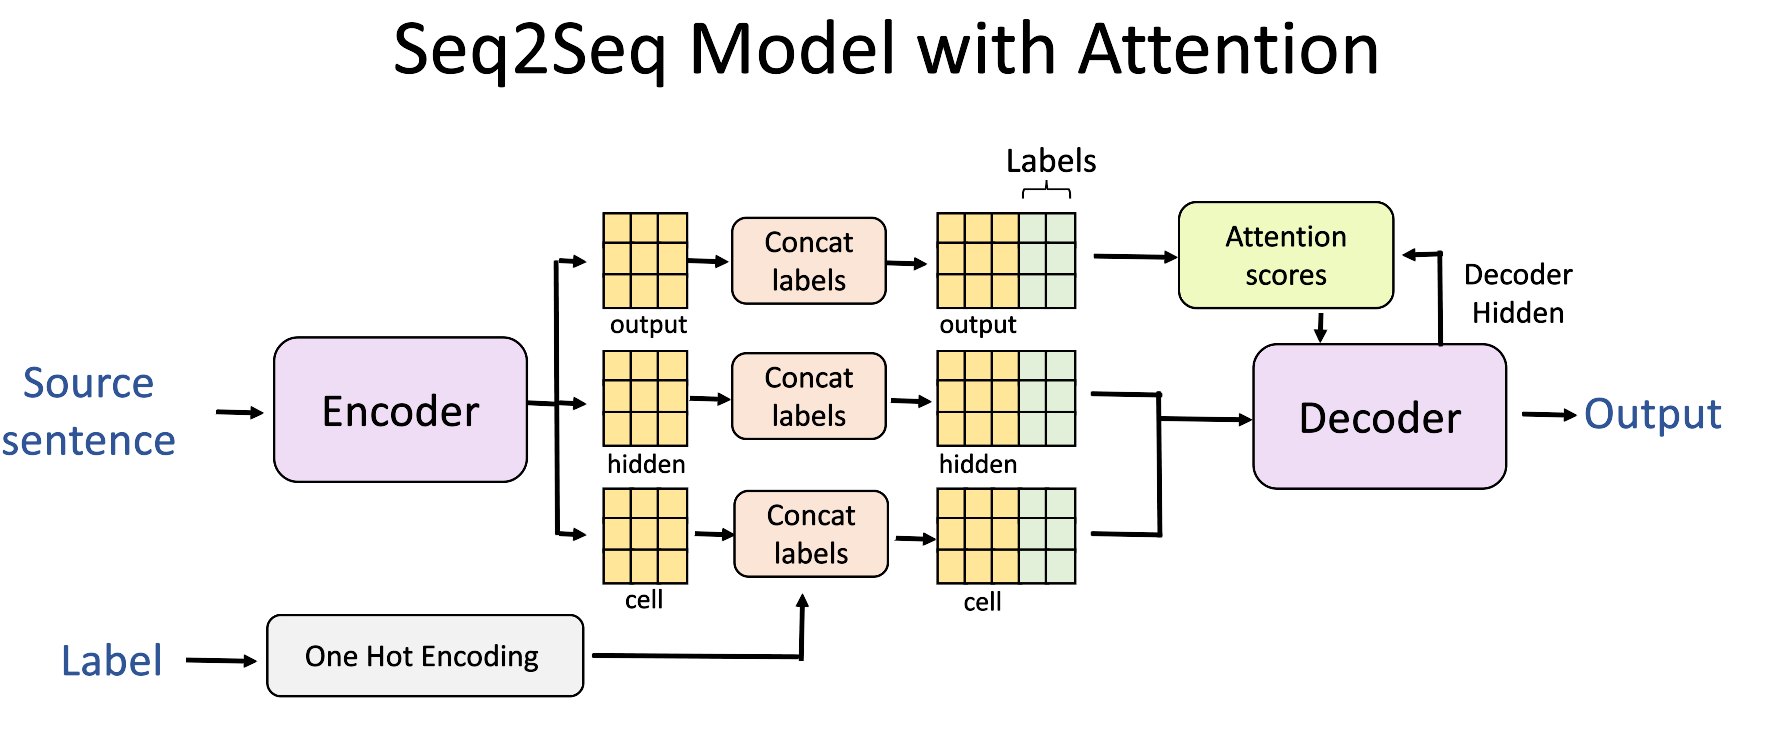](http://)

# Encoder

In [21]:
class Encode(nn.Module):
  def __init__(self, e_input, e_embedding,
                           e_hidden_size, num_layers,dropout):
    super(Encode, self).__init__()

    # Number of layers in the LSTM
    self.num_layers = num_layers

    # number of features for LSTM to remember
    self.hidden_size = e_hidden_size

    # No of final nodes to drop in order to avoid overfitting
    self.dropout = nn.Dropout(0.5)

    # applying a embedding on the given input_size i.e. the hindi vocabulary 
    self.embedding = nn.Embedding(e_input, e_embedding , padding_idx=3)
    
    #Applies a multi-layer Bi-LSTM to an input sequence.

    self.LSTM = nn.LSTM(e_embedding,e_hidden_size,num_layers, dropout = 0.5 , bidirectional=True)

    for weight_name, values in self.LSTM.named_parameters():
        if 'weight_ih' in weight_name:
            nn.init.kaiming_normal_(values)
        elif 'weight_hh' in weight_name:
            nn.init.orthogonal_(values)
    weight_param_list = self.LSTM._all_weights

    # Setting the value of the forget gate bias =1 , so as to enable it to learn more by default
    for ind_list in weight_param_list:
      for wt in ind_list:
        if "bias" in wt:
          bias = getattr(self.LSTM,wt)
          bias.data[:]=0
          bias.data[(bias.shape[0])//4:bias.shape[0]//2]=1
        
    self.linear =  nn.Linear(2*e_hidden_size , e_hidden_size)
    # Displays the weights and biases , choose the bias->0 as tried putting 1/4 to 1/2 of bias length=1
    # in order to LSTM to remember more by default but that did not improve the results on the validation set.
    #print(self.LSTM.bias)
    #print(self.LSTM.bias_ih_l0.data[:].size()) # printed 4096 and hence set the values of 1/4 -> 1/2 i.e. forget gate value to 1
    #print(self.LSTM.__dict__.keys())    
  # Dimensions of input [hindi_sentence_length, batch_size](Every sentence of the batch will have the same size since padding was used to make them of equal size)
  def forward(self, input):
    
    # Dimensions of embedding1[hindi_sentence_length , batch_size , embedding_size]
    # Here , the words of the sentence x for all the sentences of the batch size 
    # will be learning an embedding which was initially created using the constructor and function above
    # i.e. nn.Embedding 
    embedding1 = self.embedding(input)
                
    # Avoid overfitting by dropping some of the nodes
    embedding = self.dropout(embedding1)
    
    #print("input->",input)
    
    #print("embedding->",embedding)
    # The embedding is then passed through the LSTM layer
    #Dimensions of output [hindi_sentence_length , batch_size , hidden_size*2]
    #Dimensions of hidden state [num_layers*2, batch_size, hidden_size]
    encoder_out , (hidden_state , cell_state) = self.LSTM(embedding)
    
    hidden_final =torch.zeros(2,input.shape[1],hidden_state.shape[2]*2).to(device)

    # THIS IS DONE SINCE WHAT WE GET AS OUTPUT FROM A BI-LSTM IS SOMETHING LIKE THIS ::
    # [FORWARD1,BACKWARD1,FORWARD2,BACKWARD2............]
    # SO  CONCATENATED THE OUTPUTS OF THE FORWARD AND BACKWARD OF EACH OF THE 2 CONSECUTIVE HIDDEN LAYERS 
    # AND THEN FED THE RESULTANT AS THE HIDDEN LAYER OUTPUT OF THE ENCODER TO THE DECODER.
    for i in range(0,(hidden_final.shape[0])):
      hidden_final[i]=torch.cat((hidden_state[i*2,:,:],hidden_state[i*2+1,:,:]),dim=1)

    cell_final =torch.zeros(2,input.shape[1],hidden_state.shape[2]*2).to(device)

    for i in range(0,(cell_final.shape[0])):
      cell_final[i]=torch.cat((cell_state[i*2,:,:], cell_state[i*2+1,:,:]),dim=1)
    
    hidden_final = self.linear(hidden_final)
    cell_final =  self.linear(cell_final)
    
    #print("hidden state2-> ",hidden_final)
    #print("cell state2 ->" , cell_final)
    return encoder_out , (hidden_final , cell_final)


# Attention

In [22]:
class Attention(nn.Module):
  def __init__(self,e_hidden_size,d_hidden_size):

    super(Attention, self).__init__()
    self.e_hid = e_hidden_size
    self.d_hid = d_hidden_size
    self.attention  =  nn.Linear((e_hidden_size) + d_hidden_size , d_hidden_size)
    self.del_d_hidden = nn.Linear(d_hidden_size, 1)

  def forward(self,hidden,e_out,batch_size,hsentence_length):

    # We need to repeat the hidden layer of decoder "hsentence_length" number of times
    # This is because the e_out have the dimension of [hsentence_length,batch_size,hidden_dimension]
    # and since when we are trying to find attention we are searching for all words of hsentence_length and 
    # the result we want after applying the operations, i.e. the final attention vector to be of size
    # hsentence_length and hence , we need to repeat the hidden layer of decoder "hsentence_length"
    # no of times.
    # Initially-- #hidden = [num_of_layers,batch_size,d_hidden_size]
        #e_out = [hsentence_length, batch_size, e_hidden_size]
   
    hidden = hidden[:,None] 

    hidden = torch.repeat_interleave(hidden,repeats=hsentence_length,dim=1)
        
    #print("here1 --", hidden.size() , hidden.squeeze(dim=0).size())

    hidden = hidden.permute(0,1,2)

    e_out = e_out.permute(1, 0, 2)
    
    # Now :: #hidden = [batch_size,hsentence_length,d_hidden_size]
        #e_out = [batch_size,hsentence_length , e_hidden_size ]

    # Now, applying the attention to the hidden of decoder and e_out by first concatenating them in the 3rd
    # dimension and then applying an activation to it.
    #print("hidden2->", hidden.size())
    #print("eout2->",e_out.size())

    concatenated_tensor = torch.cat((hidden, e_out), dim = 2)
  
    #print(concatenated_tensor.shape , hidden.shape , e_out.shape)
    
    #print("h-->", self.e_hid , self.d_hid)
    concatenated_tensor  = self.attention(concatenated_tensor)
    
    # applying the tanh activation over the concatenated_tensor
    attn_tensor = torch.tanh(concatenated_tensor)

    #attn_tensor = [batch_size,hsentence_length, d_hidden_size]
    
    attention = self.del_d_hidden(attn_tensor) 
    # [batch size, hsentence_length , 1] 
    
    attention = attention.squeeze(dim=2)
    #attention= [batch size,hsentence_length]

    # application of softmax activation to the attention vector in order to calculate the attention scores obtained
    attention_resultant = F.softmax(attention, dim=1)
    

    # This will give a attention vector wherein for every statement present in the batch 
    # the attention vector corresponding to it will contain what is the importance of each word
    # of the sentence for the prediction of this new word so the softmax will convert the value corresponding
    # to each word of the sentence in b/w 0 and 1 , such that the sum of importance of all the words
    # of a sentence is equal to 1.

    return attention_resultant




# Decoder

In [23]:
class Decode(nn.Module):
  def __init__(self, d_input, d_embedding,hidden_size,result_size, num_layers,dropout,attn):
    
    super(Decode, self).__init__()


    # Number of layers in the lstm
    self.num_layers = num_layers
    
    # Output size of the word embedding NN
    self.embedding_size = d_embedding

    # Set the attention vector 
    self.attn = attn

    # Dimension of the NN's inside the lstm cell/ (hs,cs)'s dimension.
    self.hidden_size = hidden_size


    # The result which is obtained after the LSTM model results are passed through
    # a fully connected layer to give the final vector which contains a probability
    # corresponding to each word in the vocabulary.
    #Set the final result size to be obtained 
    self.result_size = result_size
    
    self.output_size = result_size
    # Regularization parameter
    self.dropout = nn.Dropout(0.5)

    # Shape (hindi_vocab_size,embedding_size) [input size, embedding dims]
    #The module that allows you to use Embedding is torch.nn.Embedding.
    #It takes two parameters : the vocabulary size and the dimensionality of the embedding
    self.embedding = nn.Embedding(d_input, d_embedding)
    
    self.d_embedding = d_embedding
    
    # Uni-directional LSTM Decoder
    self.LSTM = nn.LSTM(d_embedding + 2*(hidden_size-2)+2, hidden_size, num_layers, dropout = 0.5 , bidirectional=False)

    # Weight initialisation using kaiming and orthogonal initialisation
    for weight_name, values in self.LSTM.named_parameters():
        if 'weight_ih' in weight_name:
            nn.init.kaiming_normal_(values)
        elif 'weight_hh' in weight_name:
            nn.init.orthogonal_(values)
    weight_param_list = self.LSTM._all_weights

    # Setting the value of the forget gate bias =1 , so as to enable it to learn more by default
    for ind_list in weight_param_list:
      for wt in ind_list:
        if "bias" in wt:
          bias = getattr(self.LSTM,wt)
          bias.data[:]=0
          bias.data[(bias.shape[0])//4:bias.shape[0]//2]=1
   
    self.fully_connected = nn.Linear(hidden_size + 2*(hidden_size-2)+2 + d_embedding, result_size)

    self.softmax = nn.Softmax(dim=1)
  # Shape of x  [batch_size]
  def forward(self,output_from_prev,en_out,hidden_state,cell_state):

    # Shape of x (1, 32) [1, batch_size]
    output_from_prev = output_from_prev.unsqueeze(0)

    hidden_state1 = hidden_state[-1]
    # Shape(1, 32, embedding_Size) [1, batch_size, embedding dims]
    embedding1 = self.dropout(self.embedding(output_from_prev))

    #Applying the activation function to the embedding
    embedding = F.relu(embedding1)
    
    # Passing the encoder outputs (i.e. the hidden states from the encoder) and the decoder's prev layer hidden
    # unit to the attention function to get the value of the attention vector.
    # from the attention function we get the value as [batch_size,en_out.shape[0]i.e. the length of the input hindi statement]
    attention_value = self.attn(hidden_state1,en_out,embedding1.shape[1],en_out.shape[0])

    # Now we need to use this attention to create a weighted vector , which will be having the importance 
    # corresponding to each word 
    
    # now in order to get the weighted input whose dimension should be appropriate to be fed to the 
    # LSTM layer i.e. it should be of the dimensions ->[1,batch_size,embedding_size+weighted_vector concatenated to it]
    # so attention value from batch_size,input_hindi_length ----> [batch_size,1,input_hindi_length] and 
     
    attention_value  = attention_value.unsqueeze(dim=1)

    # en_out -> [batch_size , input_hindi_length ,e_hidden_size]

    en_out  = en_out.permute(1,0,2)

    # then multiplying both of them to give the weighted vector -> [batch_size,1,e_hidden_size]
    
    weighted_tensor = torch.matmul(attention_value,en_out)

    # and then concatenating the embedding[1,batch_size,embedding_size] and the weighted vector [batch_size,1,e_hidden_size] (first permute to -> [1,batch_size,e_hidden_size])
    weighted_tensor = weighted_tensor.permute(1,0,2)
    
    #print(weighted_tensor.size())
    #print(embedding.size())
    concats = torch.cat((embedding,weighted_tensor),dim=2)
   

    # and then feeding as input to the LSTM   
    results, (hidden_state,cell_state) = self.LSTM(concats,(hidden_state,cell_state))

    # Shape of outputs [1, batch_size , hidden_size]
    # Shape[num_layers, batch_size , hidden_size] (passing encoder's hs, cs - context vectors)
   # results, hidden_state = self.GRU(embedding, hidden_state)

    #results = results[:, :, :2*self.hidden_size] + results[:, :, 2*self.hidden_size:]

    #Before putting the lstm output into fc layer it has to be flattened out as done above using
    # nn.Linear
     #Output Size =  1*Batch_size*target_vocab_size -> as for each word in all the  batches simulatenously
    # processing , there would be a prob associated with every word present in the vocab and the word with 
    # max prob is choosen as the value to be fed to the next LSTM input to 1st layer (this is done later on
     # in the training step)
    
    # applying a final linear layer 
    english_pred = self.fully_connected(torch.cat((results,weighted_tensor,embedding),dim=2))
    
    
    # Shape --> predictions [batch_size , output_size]
    
    english_pred = english_pred.squeeze(0)

    # return the resultant outputs
    return english_pred,(hidden_state , cell_state)



# Seq2Seq

In [24]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, output_size, embedding_size, hidden_size, n_layers, n_labels, dropout, device):
        super().__init__()
        # create encoder class object
        self.encoder = Encode(input_size, embedding_size, hidden_size, n_layers, dropout).to(device)
        # create attention class object
        self.attention = Attention(hidden_size+n_labels,2*hidden_size+n_labels).to(device)  
        # create decoder class object and also pass the attention object to it
        self.decoder = Decode(output_size, embedding_size, hidden_size+n_labels, output_size, n_layers, dropout,self.attention).to(device)
        self.device = device
        
    def forward(self, input_sentence, target_output_sentence, labels, teacher_forcing_ratio = 0.5):
        input_sen_len = input_sentence.shape[0]
        batch_size = input_sentence.shape[1]
        output_sen_len = target_output_sentence.shape[0]
        output_vocab_size = self.decoder.output_size
        
        #tensor to store predicted words by the decoder
        predicted_word_indexes = torch.zeros(output_sen_len, batch_size, output_vocab_size).to(self.device)

        #pass the input hindi sentence into the encoder 
        e_output, (hidden,cell) = self.encoder(input_sentence)

        # modified hidden , cell and the output latent space
        hidden = latent_space_concat(hidden, labels)
        e_output =  latent_space_concat(e_output,labels)
        cell =  latent_space_concat(cell,labels)
        
        #first input to the decoder is always the init_token, i.e., <sos> token
        decoder_input = target_output_sentence[0] 
        
        # iterating over all the words in the output_sen_len 
        for i in range(1, output_sen_len):
            #pass the previous word along with the hidden and cell states of encoder into the decoder 
            output, (hidden,cell) = self.decoder(decoder_input,e_output,hidden,cell)

            #append the next predicted word
            predicted_word_indexes[i] = output
            
            # usage of teacher forcing ratio
            use_teacher_forcing = random.random() < teacher_forcing_ratio
            
            # finding the word with maximum score
            best_word = output.argmax(1)
            
            if use_teacher_forcing:
              decoder_input = target_output_sentence[i]
            else:
              decoder_input = best_word

        return predicted_word_indexes

# Training phase

HYPER-PARAMETERS


In [25]:
MAX_LENGTH =400
input_size = src_field.vocab_size
output_size = tgt_field.vocab_size
#hyperparameters
num_epochs = 20
learning_rate = 0.001          
hidden_size = 256
embedding_size = 256           #same for both LSTM (encoder and decoder)
dropout = 0.5
n_layers = 2
n_labels = 2

In [26]:
#initialize the object of Seq2Seq class
model = Seq2Seq(input_size, output_size, embedding_size, hidden_size, n_layers, n_labels, dropout, device).to(device)

The parameter initialization has been done as per the paper :  https://arxiv.org/pdf/1409.3215.pdf

In [27]:
#initialize the parameters
def init_weights(model):
    for name, parameter in model.named_parameters():
        nn.init.uniform_(parameter.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encode(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(22011, 256, padding_idx=3)
    (LSTM): LSTM(256, 256, num_layers=2, dropout=0.5, bidirectional=True)
    (linear): Linear(in_features=512, out_features=256, bias=True)
  )
  (attention): Attention(
    (attention): Linear(in_features=772, out_features=514, bias=True)
    (del_d_hidden): Linear(in_features=514, out_features=1, bias=True)
  )
  (decoder): Decode(
    (attn): Attention(
      (attention): Linear(in_features=772, out_features=514, bias=True)
      (del_d_hidden): Linear(in_features=514, out_features=1, bias=True)
    )
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(44789, 256)
    (LSTM): LSTM(770, 258, num_layers=2, dropout=0.5)
    (fully_connected): Linear(in_features=1028, out_features=44789, bias=True)
    (softmax): Softmax(dim=1)
  )
)

In [ ]:
def translate_sentence(model, src_sentence, src_field, tgt_field, label, device , max_length=400):
    #tokenize the hindi sentence
    src_tokens = lang_tokenizer("ENGLISH",src_sentence)

    #convert it into tensor
    sentence_tensor = src_field.tokens2tensor(src_tokens).long()  
    label_arr = torch.as_tensor(onehot_encoder.fit_transform(np.array([label]).reshape(-1, 1)).toarray(),dtype=torch.float32).to(device).long()
    

    with torch.no_grad():
        #pass the source sentence into the encoder to get the hidden and cell states
        e_output,(hidden,cell) = model.encoder(sentence_tensor)
    
    
    # modified hidden space, output space and cell space
    hidden = latent_space_concat(hidden, label_arr)
    e_output = latent_space_concat(e_output,label_arr)
    cell =  latent_space_concat(cell,label_arr)

    predicted_word_indices = [tgt_field.word2index["<sos>"]]              #index of <sos> in english vocab
    predicted_sentence = ""

    #repeat until the len of predicted sentence is less than max_length or the decoder predicts <eos>
    while len(predicted_word_indices)<max_length and predicted_word_indices[-1]!= tgt_field.word2index["<eos>"]:
        prev_word = [predicted_word_indices[-1]]             
        prev_word = torch.tensor(prev_word).to(device)                  #convert into tensor
        best_word = ""
        with torch.no_grad():
            '''
             pass the last predicted word along with the hidden and cell state of the encoder
             into the decoder to get the next predicted word
            '''

            output,(hidden,cell) = model.decoder(prev_word,e_output,hidden ,cell)

            _ ,best_word = output.data.topk(1)                          #get the best predicted word index
          
        predicted_word_indices.append(best_word.item())                 #append it to the list of predicted word indices
        predicted_sentence += tgt_field.index2word[best_word.item()]+" "  #append the word corresponding to the predicted index

    translated_sentence = predicted_sentence.replace("<sos>","").replace("<eos>","")
    return translated_sentence


In [ ]:
def train_batch_list(model, batch_list, criterion, encoder_optimizer, decoder_optimizer):
    for idx,(input_sentence,target_sentence,labels) in enumerate(batch_list):
         #get hindi and their corresponding english sentences from the batch
        src = torch.transpose(torch.as_tensor(input_sentence, dtype=torch.int64),0,1).to(device)
        tgt = torch.transpose(torch.as_tensor(target_sentence, dtype=torch.int64),0,1).to(device)
        labels = torch.as_tensor(labels, dtype=torch.float32).to(device)
        
         # eliminating the accumulating gradients 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()    

        #pass the hindi and their corresponding english sentences into the model to get the predicted sentence     
        predicted_sentence = model(src, tgt, labels) 

        #adjust the shapes
        predicted_sentence = predicted_sentence[1:].reshape(-1, predicted_sentence.shape[2])
        tgt = tgt[1:].reshape(-1)

        #calculate loss    
        loss = criterion(predicted_sentence,tgt)
        
        #backpropagate loss
        loss.backward()

        #clip the gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        #opitimize the parameters according to the propagated loss
        encoder_optimizer.step()
        decoder_optimizer.step()
    return loss 

In [ ]:
# reference sentence taken to test on various epochs
ref_sen = "How are you?"

In [ ]:
# train function 
def train(model, batch_list,num_epochs=num_epochs):
    total_loss = 0

    #initialize the optimizer and the criterion(Loss function) to be used
    encoder_optimizer = optim.Adam(model.encoder.parameters(),lr=learning_rate)       #using Adam optimizer for encoder 
    decoder_optimizer = optim.Adam(model.decoder.parameters(),lr=learning_rate)       #using Adam optimizer for decoder
    criterion = nn.CrossEntropyLoss(ignore_index = tgt_field.word2index["<pad>"])       #using CrossEntropyLoss function
    

    for epoch in range(num_epochs):

        model.eval()
        ref_out = translate_sentence(model, ref_sen, src_field, tgt_field, "FRENCH", device, max_length=400)
        print(f"french :: {ref_out}")
        ref_out = translate_sentence(model, ref_sen, src_field, tgt_field,"SPANISH",device, max_length=400)
        print(f"spanish :: {ref_out}")
        model.train()


        #calculate loss for epoch
        loss = train_batch_list(model,batch_list,criterion,encoder_optimizer,decoder_optimizer)
        total_loss += loss.item()

        #save model
        torch.save(model.state_dict(),f"proj_model_{epoch+1}_new.pt")
        
        print(f'\n\nEpoch: {epoch+1}/{num_epochs}     Loss: {loss.item():.4f}')  

    print(f"\n\n Total loss ::: {total_loss/len(batch_list):.4f}")


In [ ]:
# function call to the train function
train(model,batch_list,num_epochs=num_epochs)

In [ ]:
#save model
torch.save(model.state_dict(),"model_saved.pt" )

In [ ]:
model.eval()